Update network architecture and try different style image

# Import

In [1]:
import os
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from IPython.core.debugger import set_trace
from PIL import Image

In [2]:
sys.path.append('../../')

In [3]:
from style_transfer.data import *
from style_transfer.models import *

# Config

In [4]:
dir_data = Path('../../data')

# Utility

In [5]:
def save_checkpoint(model, optimizer, file_checkpoint):
    file_checkpoint.parent.mkdir(exist_ok=True)
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict()},
               file_checkpoint)

In [6]:
def load_checkpoint(model, optimizer, file_checkpoint):
    checkpoint = torch.load(file_checkpoint)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [7]:
def epoch(model, dl, loss, optimizer, device, mode):
    metrics_e, total_e = dict.fromkeys(loss.get_metric_names(), 0), 0
    model.train() if mode == 'trn' else model.eval()
    with torch.set_grad_enabled(mode == 'trn'):
        for X, y in dl:
            X, y = X.to(device), y.to(device)

            # Get loss and batch metrics
            if mode == 'trn': optimizer.zero_grad()            
            y_hat = model(X)
            l, metrics_b = loss(y_hat, y)            
            if mode == 'trn': l.backward(), optimizer.step()

            # Scale metrics
            for key in metrics_e.keys(): metrics_e[key] += metrics_b[key]*X.shape[0]
            total_e += X.shape[0] # Track total number of items in epoch

    # Get mean of metrics
    for key in metrics_e.keys(): metrics_e[key] /= total_e
    return metrics_e

# Train

Config

In [8]:
# Config
num_workers = 4
pin_memory = True
dir_styl = dir_data/'style'
dir_cont = dir_data/'content'

# Device
device = torch.device('cuda')

# Model
in_channels = 3
layout_encoder = [[  32, 7, 1],
                  [  64, 5, 1],
                  [ 128, 3, 1],
                  [ 256, 3, 8]]
encoder = get_encoder(in_channels, layout_encoder)
model = AutoEncoder(encoder)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters())

Train

In [9]:
def _get_dl_trn(sz, batch_size, num_samples):
    tfms = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225])])

    return SubsetDataloader(ImgCSVDataset(dir_cont/f'formatted_{sz}'/'trn'/'imgs',
                                          dir_cont/'trn.csv', 
                                          tfms=tfms), 
                            batch_size=batch_size,
                            num_workers=num_workers,
                            pin_memory=pin_memory,
                            num_samples=num_samples)

In [10]:
def _set_lr(lr): 
    for p in optimizer.param_groups: 
        p['lr'] = lr

In [11]:
def _fit(num_epochs, dl_trn, loss, file_checkpoint):    
    %matplotlib notebook

    fig, axs = plt.subplots(2, figsize=(8,8))
    for num_epoch in range(num_epochs):    
        # Train
        metrics_trn = epoch(model, dl_trn, loss, optimizer, device, 'trn')

        # Print metrics
        print(pd.DataFrame(metrics_trn, index=[num_epoch]).to_string(header=num_epoch == 0,
                                                                     float_format=lambda x: f'{x:14.2f}',
                                                                     col_space=8))
        # Checkpoint
        save_checkpoint(model, optimizer, file_checkpoint)

        # Plot Images
        model.eval()
        with torch.no_grad():
            y_hat = model(img_test)
            axs[0].imshow(denorm(torch2np(img_test[0])))
            axs[1].imshow(denorm(torch2np(y_hat[0])))

        # Update plot
        fig.canvas.draw()

    %matplotlib inline

In [12]:
def _train(num_epochs, lr, sz, batch_size, num_samples, loss, name):
    _set_lr(lr)
    dl_trn = _get_dl_trn(sz, batch_size, num_samples)
    _fit(num_epochs, dl_trn, loss, Path(f'checkpoints/{name}.pth'))

### Stage 1

<IPython.core.display.Javascript object>


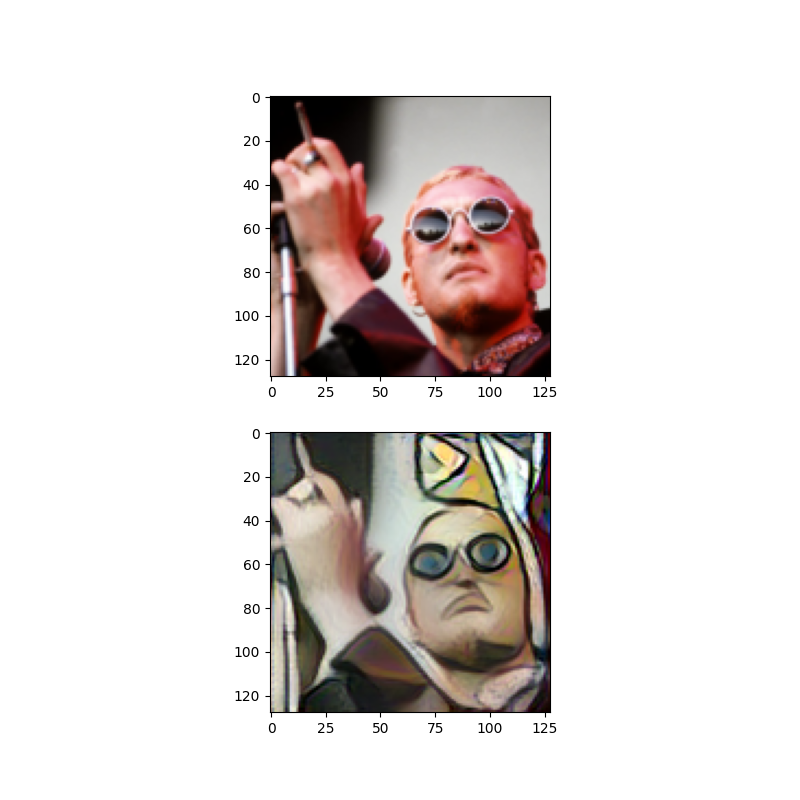

                      l        ls_s[0]        ls_s[1]        ls_s[2]        ls_s[3]        ls_c[0]
0              64215.87        8077.22       12035.47       18991.77         563.15       24548.26
1              40814.64         721.89        2512.39       10018.73         491.00       27070.62
2              37995.82         446.79        1689.25        8396.72         452.31       27010.75
3              36502.25         338.75        1370.75        7609.44         422.24       26761.07
4              35457.90         286.33        1203.55        7131.55         404.96       26431.50
5              34645.94         263.09        1116.17        6829.56         395.63       26041.48
6              34069.81         250.20        1058.40        6622.21         389.59       25749.41
7              33438.80         241.28        1016.41        6470.00         384.89       25326.22
8              32977.96         235.46         978.55        6350.17         380.53       25033.25
9         

82             24990.28         196.20         764.16        5799.30         309.57       17921.05
83             24943.50         195.92         763.11        5795.37         308.68       17880.42
84             24955.54         196.03         764.72        5804.46         308.21       17882.12
85             24909.62         196.04         762.54        5797.60         308.19       17845.26
86             24872.01         197.11         765.25        5799.14         307.98       17802.54
87             24847.10         196.84         763.19        5800.58         307.43       17779.05
88             24783.84         196.59         762.06        5795.76         308.12       17721.31
89             24764.47         195.38         758.30        5791.02         307.35       17712.42
90             24732.84         196.72         761.48        5796.74         307.84       17670.07
91             24723.55         197.53         763.51        5796.93         307.38       17658.20
92        

In [13]:
lr = 1e-5
sz = 256
batch_size =  4
num_samples= 10000    

img_test = Image.open(dir_cont/'artists'/'layne.jpg')
img_test = F.center_crop(F.resize(img_test, 128), 128)
img_test = img2tensor(img_test)

loss = FeatureLoss(models.vgg16(pretrained=True).features, 
                   F.center_crop(F.resize(Image.open(dir_styl/'dora.jpg'), 128), 128), 
                   sz, 
                   [0,1,2,3], 
                   [2],
                   [1e8, 1e8, 1e8, 1e8],
                   [1e3])

_train(100, lr, sz, batch_size, num_samples, loss, 'stage1')